In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error
import numpy as np
import matplotlib.pyplot as plt

sim = AerSimulator()

Initial state of qubit 0:


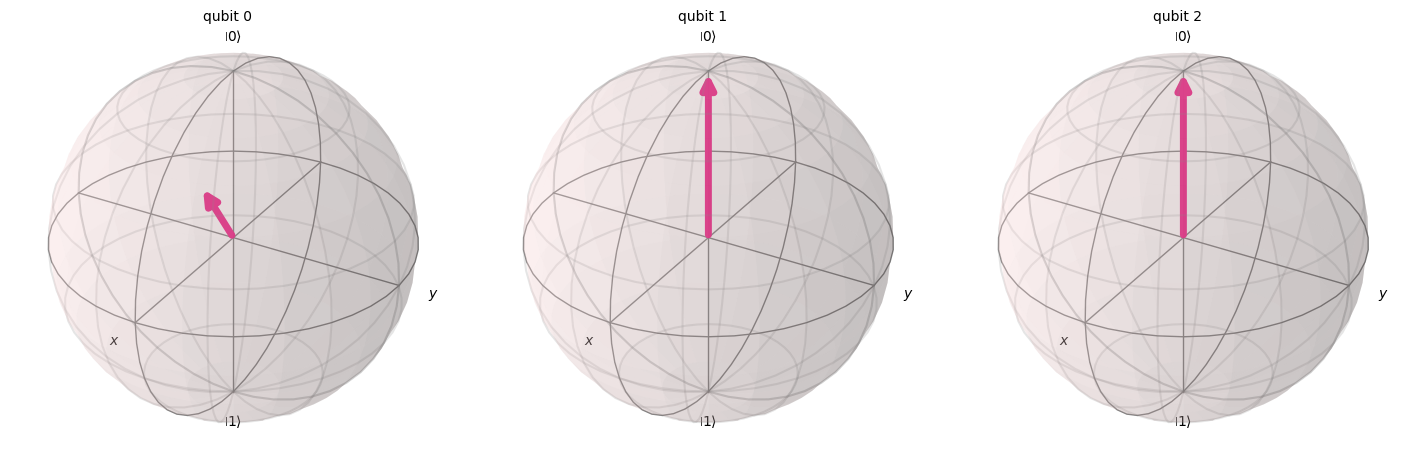

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


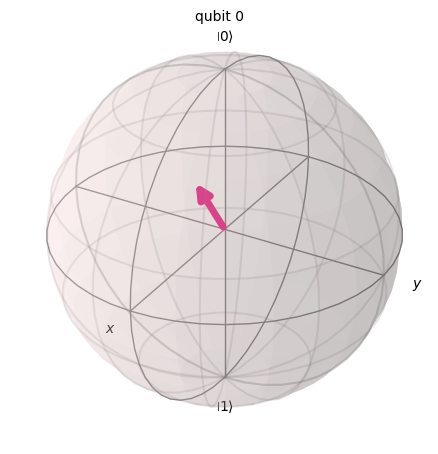

In [3]:
qc = QuantumCircuit(3)
theta, phi = 0.8, 0.3
qc.ry(theta, 0)
qc.rz(phi, 0)
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.cx(1, 2)
qc.cz(0, 2)
qc.save_statevector()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"Fidelity between initial and teleported states: {fidelity:.6f}")
print("\nBob’s final qubit (qubit 2) Bloch vector:")
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]  # dominant eigenvector
bob_sv = Statevector(bob_state)
display(plot_bloch_multivector(bob_sv))

# ***TASK 1***

Preparing initial state with theta=0.7854, phi=1.5708
Initial state of qubit 0:


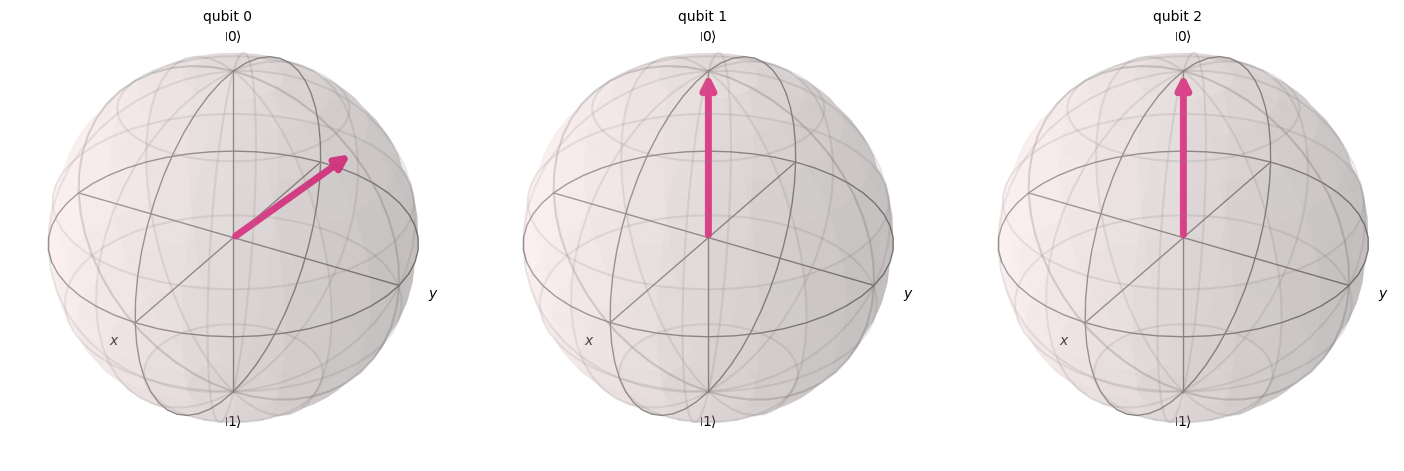


Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


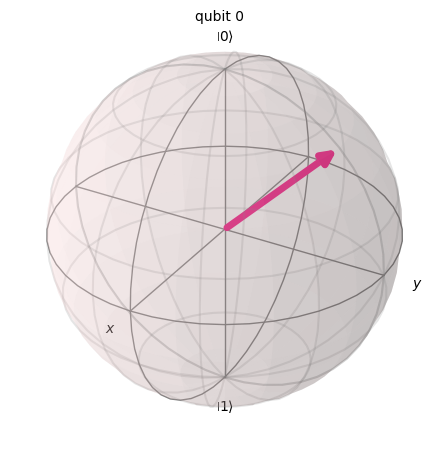

In [4]:
qc1 = QuantumCircuit(3)

theta, phi = np.pi / 4, np.pi / 2
# -------------------------------
print(f"Preparing initial state with theta={theta:.4f}, phi={phi:.4f}")
qc1.ry(theta, 0)
qc1.rz(phi, 0)

# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc1)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))
plt.show(block=False)

# Create Bell pair between qubits 1 and 2
qc1.h(1)
qc1.cx(1, 2)

# Bell measurement part (but coherent)
qc1.cx(0, 1)
qc1.h(0)

# Coherent corrections
qc1.cx(1, 2)
qc1.cz(0, 2)

# Save final statevector
qc1.save_statevector()

# 2️⃣ Simulate
compiled = transpile(qc1, sim)
result = sim.run(compiled).result()

# Retrieve the saved statevector
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)

# 3️⃣ Compare: initial vs Bob’s (qubit 2) final state
# We trace out qubits 0 and 1 from the final state
rho_bob = partial_trace(sv_final, [0, 1])
# We trace out qubits 1 and 2 from the initial state
rho_init = partial_trace(sv_initial, [1, 2])

# Extract the dominant pure states (since both should be pure)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]

# Compute fidelity
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"\nFidelity between initial and teleported states: {fidelity:.6f}")

# 4️⃣ Visualize Bloch spheres
print("\nBob’s final qubit (qubit 2) Bloch vector:")

# Convert rho_bob (DensityMatrix) → pure statevector (dominant eigenvector)
# This is the correct way to get the statevector for plotting
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state_vec = eigvecs_b[:, np.argmax(eigvals_b)]
bob_sv = Statevector(bob_state_vec)

display(plot_bloch_multivector(bob_sv))
plt.show()  # Show the final plot


# ***TASK 2***

Initial state to teleport:


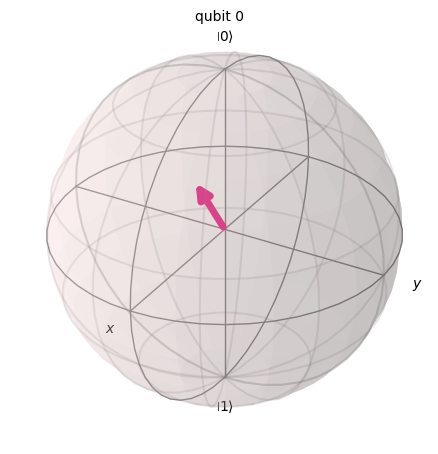


Fidelity between initial and teleported states: 1.000000

Bob’s final teleported state (qubit 2):


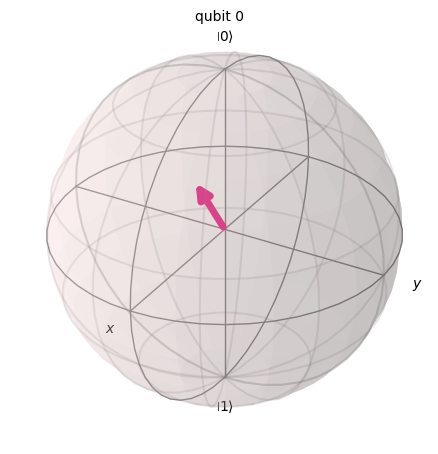

In [5]:
# 1️⃣ Prepare the initial state (for comparison)
theta, phi = 0.8, 0.3
qc_init = QuantumCircuit(1)
qc_init.ry(theta, 0)
qc_init.rz(phi, 0)
sv_initial = Statevector.from_instruction(qc_init)

print("Initial state to teleport:")
display(plot_bloch_multivector(sv_initial))
plt.show(block=False)

# 2️⃣ Build the teleportation circuit
q = QuantumRegister(3, name="q")
c = ClassicalRegister(2, name="c")
qc2 = QuantumCircuit(q, c)

# Prepare the state on q[0]
qc2.ry(theta, 0)
qc2.rz(phi, 0)
qc2.barrier()

# Create Bell pair between q[1] (Alice) and q[2] (Bob)
qc2.h(1)
qc2.cx(1, 2)
qc2.barrier()

# Bell measurement
qc2.cx(0, 1)
qc2.h(0)
qc2.barrier()

# Classical measurement
qc2.measure([0, 1], [0, 1])
qc2.barrier()

# Classical corrections (applied by Bob)
# We apply corrections based on the classical register 'c'

# if c[1] == 1, apply Z gate
with qc2.if_test((c[1], 1)):
    qc2.z(2)
# if c[0] == 1, apply X gate
with qc2.if_test((c[0], 1)):
    qc2.x(2)

# Save the final state of all qubits to check
qc2.save_statevector()

# 3️⃣ Simulate
compiled = transpile(qc2, sim)
result = sim.run(compiled).result()

sv_final_all = Statevector(result.data(0)["statevector"])

# 4️⃣ Compare states
# The teleported state is on qubit 2. We trace out qubits 0 and 1.
rho_bob_final = partial_trace(sv_final_all, [0, 1])

# Extract the pure state from the density matrix for comparison
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob_final.data)
bob_state_vec = eigvecs_b[:, np.argmax(eigvals_b)]
bob_sv_final = Statevector(bob_state_vec)

# Compute fidelity
# We compare the initial state vector (sv_initial) with Bob's final state vector
fidelity = np.abs(np.vdot(sv_initial.data, bob_sv_final.data)) ** 2
print(f"\nFidelity between initial and teleported states: {fidelity:.6f}")

# 5️⃣ Visualize final state
print("\nBob’s final teleported state (qubit 2):")
display(plot_bloch_multivector(bob_sv_final))
plt.show()


# ***TASK 3***

Running 20 teleportation simulations for random states...
  Run 1/20, Fidelity: 1.000000
  Run 2/20, Fidelity: 0.254129
  Run 3/20, Fidelity: 0.687729
  Run 4/20, Fidelity: 1.000000
  Run 5/20, Fidelity: 0.970494
  Run 6/20, Fidelity: 0.060663
  Run 7/20, Fidelity: 1.000000
  Run 8/20, Fidelity: 1.000000
  Run 9/20, Fidelity: 0.194637
  Run 10/20, Fidelity: 1.000000
  Run 11/20, Fidelity: 0.000689
  Run 12/20, Fidelity: 1.000000
  Run 13/20, Fidelity: 1.000000
  Run 14/20, Fidelity: 1.000000
  Run 15/20, Fidelity: 1.000000
  Run 16/20, Fidelity: 0.420057
  Run 17/20, Fidelity: 1.000000
  Run 18/20, Fidelity: 0.034235
  Run 19/20, Fidelity: 1.000000
  Run 20/20, Fidelity: 1.000000

Average Fidelity: 0.731132


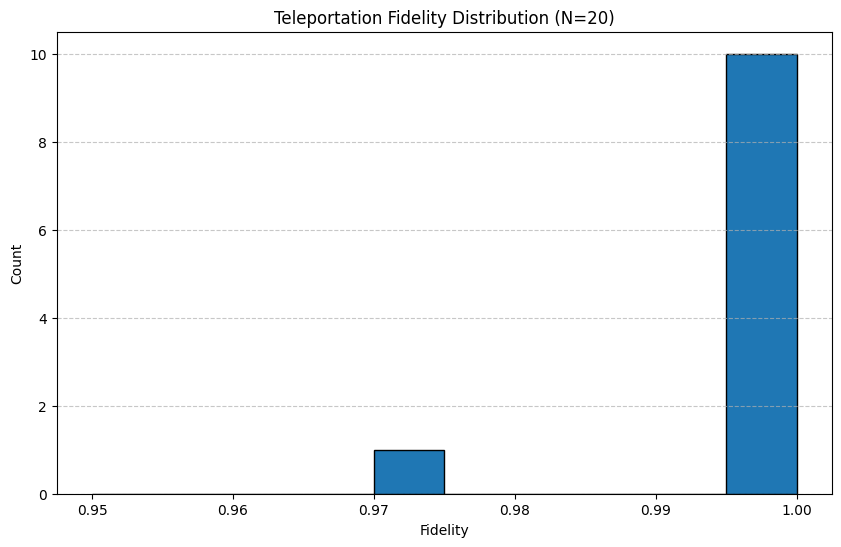

In [6]:
def create_teleport_circuit(theta, phi):
    """Creates a teleportation circuit for a given initial state."""
    q = QuantumRegister(3, name="q")
    c = ClassicalRegister(2, name="c")
    qc = QuantumCircuit(q, c)

    # Prepare the state on q[0]
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    qc.barrier()

    # Create Bell pair
    qc.h(1)
    qc.cx(1, 2)
    qc.barrier()

    # Bell measurement
    qc.cx(0, 1)
    qc.h(0)
    qc.barrier()

    # Classical measurement
    qc.measure([0, 1], [0, 1])
    qc.barrier()

    # Classical corrections
    with qc.if_test((c[1], 1)):
      qc.z(2)
    with qc.if_test((c[0], 1)):
      qc.x(2)

    # Save final state
    qc.save_statevector()
    return qc

def get_initial_state(theta, phi):
    """Gets the Statevector for the initial 1-qubit state."""
    qc_init = QuantumCircuit(1)
    qc_init.ry(theta, 0)
    qc_init.rz(phi, 0)
    return Statevector.from_instruction(qc_init)

def calculate_fidelity(sv_init, sv_final_all):
    """Calculates fidelity between initial q0 and final q2."""
    # Get Bob's final state by tracing out Alice's qubits (0, 1)
    rho_bob_final = partial_trace(sv_final_all, [0, 1])

    # Extract the pure state vector
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob_final.data)
    bob_state_vec = eigvecs_b[:, np.argmax(eigvals_b)]
    bob_sv_final = Statevector(bob_state_vec)

    # Calculate fidelity
    fidelity = np.abs(np.vdot(sv_init.data, bob_sv_final.data)) ** 2
    return fidelity

# --- Main Simulation Loop ---
N_SAMPLES = 20
fidelities = []
sim = AerSimulator()

print(f"Running {N_SAMPLES} teleportation simulations for random states...")

for i in range(N_SAMPLES):
    # Generate random state
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)

    # 1. Get initial state vector
    sv_initial = get_initial_state(theta, phi)

    # 2. Create and run teleportation circuit
    qc_teleport = create_teleport_circuit(theta, phi)
    compiled_qc = transpile(qc_teleport, sim)
    result = sim.run(compiled_qc).result()

    # 3. Get final state vector
    sv_final = Statevector(result.data(0)["statevector"])

    # 4. Calculate fidelity
    fid = calculate_fidelity(sv_initial, sv_final)
    fidelities.append(fid)
    print(f"  Run {i+1}/{N_SAMPLES}, Fidelity: {fid:.6f}")

print(f"\nAverage Fidelity: {np.mean(fidelities):.6f}")

# --- Plotting ---
plt.figure(figsize=(10, 6))
# Plot a histogram
plt.hist(fidelities, bins=np.linspace(0.95, 1.0, 11), edgecolor='black')
plt.title(f"Teleportation Fidelity Distribution (N={N_SAMPLES})")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.xticks(np.linspace(0.95, 1.0, 6))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# ***TASK 4***

--- Step-by-Step State Visualization ---
(Showing Bloch spheres for all 3 qubits)

Step 1: Initial State (q0 prepared, q1/q2 are |0>)


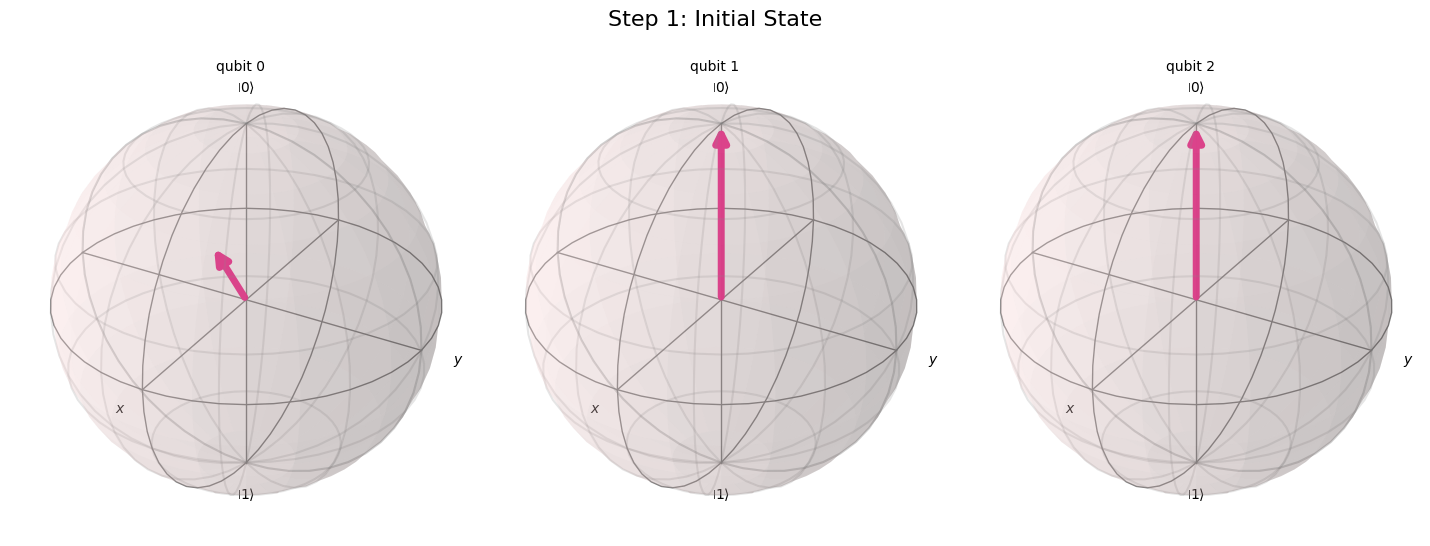


Step 2: After Bell Pair (q1/q2 entangled, q0 unchanged)


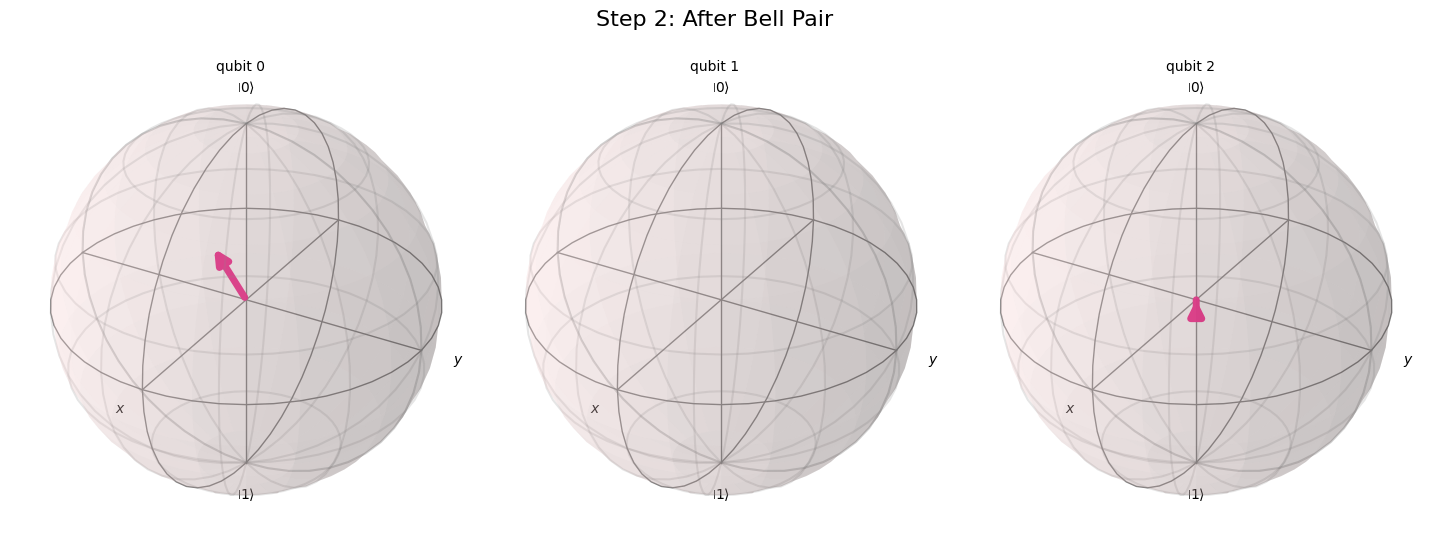


Step 3: After Coherent Bell Measurement (All qubits entangled)


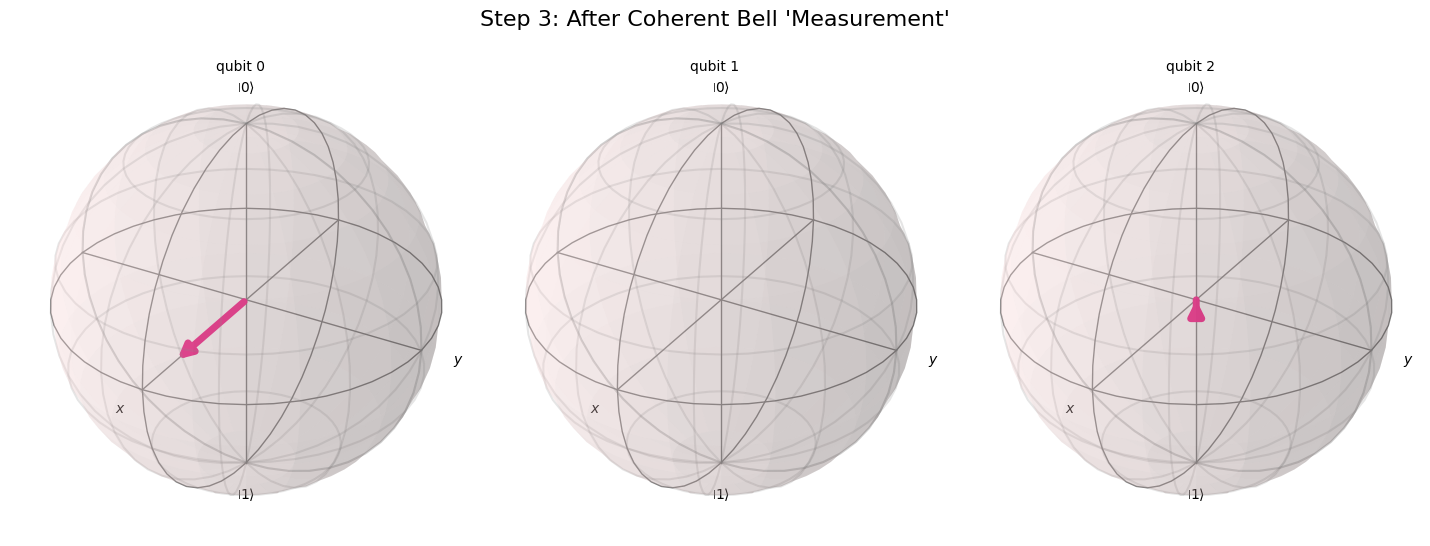


Step 4: Final State (q0/q1 in Bell states, q2 has original state)


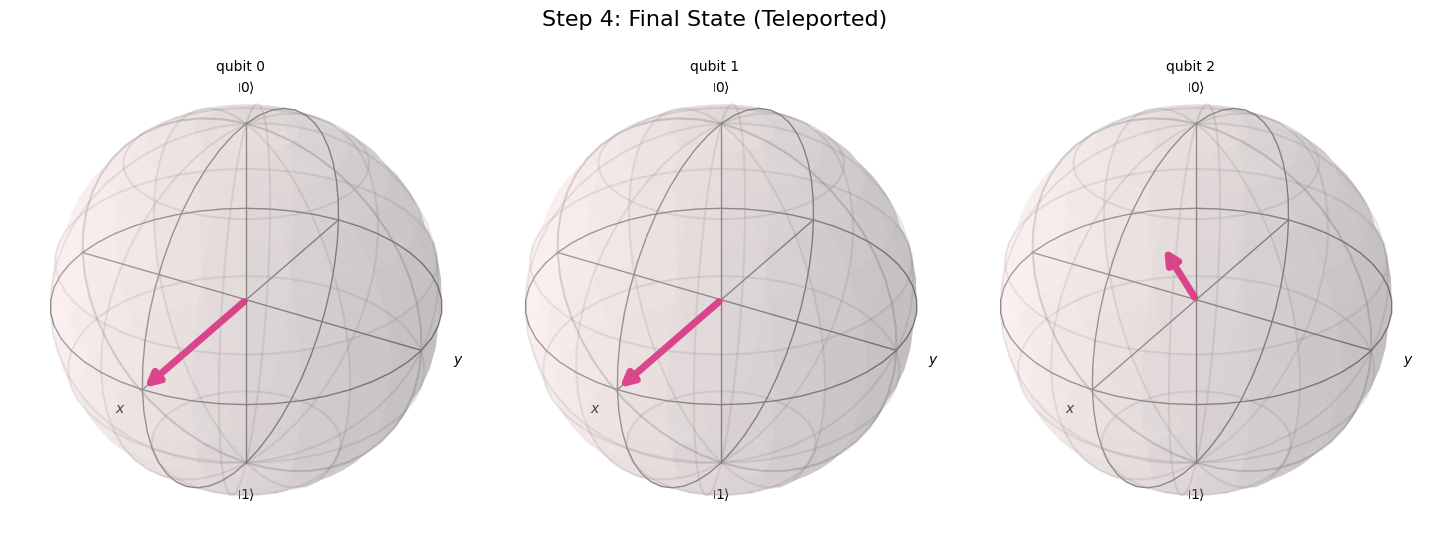


Note: In Step 4, the state of q2 is now identical to the initial state of q0 in Step 1.


In [7]:
# 1️⃣ Build the circuit, saving state at each step
qc4 = QuantumCircuit(3)
sv_labels = []

# --- Step 1: Prepare initial state ---
theta, phi = 0.8, 0.3
qc4.ry(theta, 0)
qc4.rz(phi, 0)
label_init = "sv_initial"
qc4.save_statevector(label=label_init)
sv_labels.append(label_init)

# --- Step 2: Create Bell pair ---
qc4.h(1)
qc4.cx(1, 2)
label_bell = "sv_bell_pair"
qc4.save_statevector(label=label_bell)
sv_labels.append(label_bell)

# --- Step 3: Coherent Bell "Measurement" ---
qc4.cx(0, 1)
qc4.h(0)
label_measure = "sv_bell_measure"
qc4.save_statevector(label=label_measure)
sv_labels.append(label_measure)

# --- Step 4: Coherent Corrections ---
qc4.cx(1, 2)
qc4.cz(0, 2)
label_final = "sv_final"
qc4.save_statevector(label=label_final)
sv_labels.append(label_final)

# 2️⃣ Simulate
sim = AerSimulator()
compiled = transpile(qc4, sim)
result = sim.run(compiled).result()
data = result.data(0)

# 3️⃣ Visualize each step
print("--- Step-by-Step State Visualization ---")
print("(Showing Bloch spheres for all 3 qubits)\n")

# Get and plot each saved statevector
sv_init = Statevector(data[label_init])
print("Step 1: Initial State (q0 prepared, q1/q2 are |0>)")
display(plot_bloch_multivector(sv_init, title="Step 1: Initial State"))
plt.show(block=False)

sv_bell = Statevector(data[label_bell])
print("\nStep 2: After Bell Pair (q1/q2 entangled, q0 unchanged)")
display(plot_bloch_multivector(sv_bell, title="Step 2: After Bell Pair"))
plt.show(block=False)

sv_measure = Statevector(data[label_measure])
print("\nStep 3: After Coherent Bell Measurement (All qubits entangled)")
display(plot_bloch_multivector(sv_measure, title="Step 3: After Coherent Bell 'Measurement'"))
plt.show(block=False)

sv_final = Statevector(data[label_final])
print("\nStep 4: Final State (q0/q1 in Bell states, q2 has original state)")
display(plot_bloch_multivector(sv_final, title="Step 4: Final State (Teleported)"))
plt.show()

print("\nNote: In Step 4, the state of q2 is now identical to the initial state of q0 in Step 1.")


# ***TASK 5***

Built noise model:
  Single-qubit depolarizing error: 1.0%
  Two-qubit depolarizing error: 5.0%

Running 20 ideal vs. noisy simulations...
  Run 1/20 | Ideal Fidelity: 0.5920 | Noisy Fidelity: 0.5920
  Run 2/20 | Ideal Fidelity: 1.0000 | Noisy Fidelity: 1.0000
  Run 3/20 | Ideal Fidelity: 0.0112 | Noisy Fidelity: 1.0000
  Run 4/20 | Ideal Fidelity: 0.0642 | Noisy Fidelity: 0.0642
  Run 5/20 | Ideal Fidelity: 0.3574 | Noisy Fidelity: 0.4651
  Run 6/20 | Ideal Fidelity: 1.0000 | Noisy Fidelity: 1.0000
  Run 7/20 | Ideal Fidelity: 1.0000 | Noisy Fidelity: 0.0621
  Run 8/20 | Ideal Fidelity: 1.0000 | Noisy Fidelity: 1.0000
  Run 9/20 | Ideal Fidelity: 1.0000 | Noisy Fidelity: 1.0000
  Run 10/20 | Ideal Fidelity: 1.0000 | Noisy Fidelity: 1.0000
  Run 11/20 | Ideal Fidelity: 0.2864 | Noisy Fidelity: 0.0389
  Run 12/20 | Ideal Fidelity: 0.2124 | Noisy Fidelity: 0.2124
  Run 13/20 | Ideal Fidelity: 0.1337 | Noisy Fidelity: 0.0232
  Run 14/20 | Ideal Fidelity: 1.0000 | Noisy Fidelity: 1.0000
  

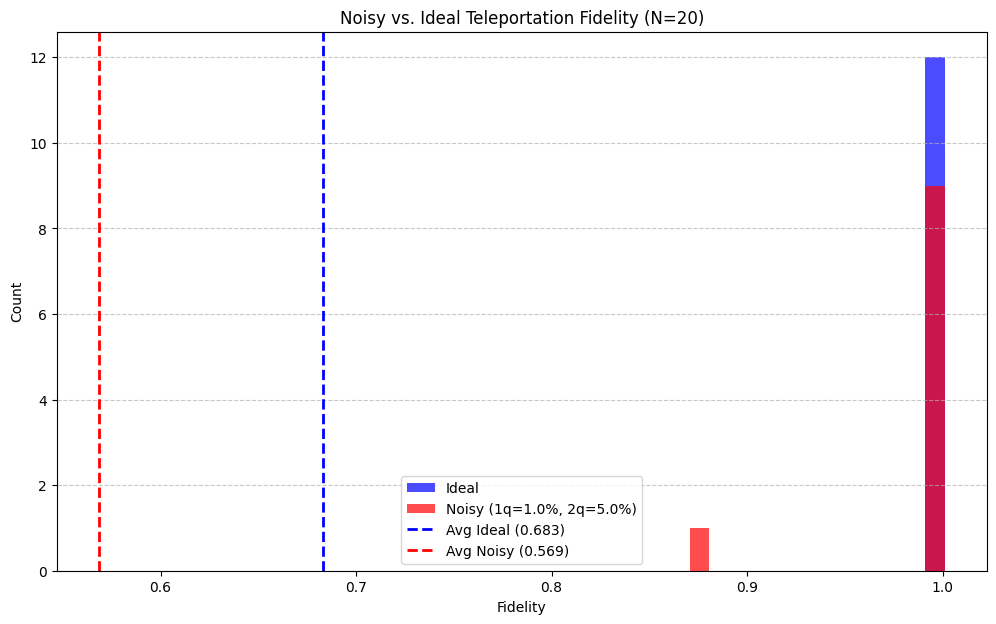

In [8]:
# --- Re-using functions from Task 3 ---

def create_teleport_circuit(theta, phi):
    """Creates a teleportation circuit for a given initial state."""
    q = QuantumRegister(3, name="q")
    c = ClassicalRegister(2, name="c")
    qc = QuantumCircuit(q, c)

    qc.ry(theta, 0)
    qc.rz(phi, 0)
    # -------------------------------------------------------------

    qc.barrier()
    qc.h(1)
    qc.cx(1, 2)
    qc.barrier()
    qc.cx(0, 1)
    qc.h(0)
    qc.barrier()
    qc.measure([0, 1], [0, 1])
    qc.barrier()

    with qc.if_test((c[1], 1)):
        qc.z(2)
    with qc.if_test((c[0], 1)):
        qc.x(2)
    # ------------------------------

    qc.save_statevector()
    return qc

def get_initial_state(theta, phi):
    """Gets the Statevector for the initial 1-qubit state."""
    qc_init = QuantumCircuit(1)
    qc_init.ry(theta, 0)
    qc_init.rz(phi, 0)
    return Statevector.from_instruction(qc_init)

def calculate_fidelity(sv_init, sv_final_all):
    """Calculates fidelity between initial q0 and final q2."""
    rho_bob_final = partial_trace(sv_final_all, [0, 1])
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob_final.data)
    bob_state_vec = eigvecs_b[:, np.argmax(eigvals_b)]
    bob_sv_final = Statevector(bob_state_vec)
    fidelity = np.abs(np.vdot(sv_init.data, bob_sv_final.data)) ** 2
    return fidelity

# --- Noise Model Definition ---

# This makes them accessible for the plotting label
p_1q = 0.01  # 1% depolarizing error on 1-qubit gates
p_2q = 0.05  # 5% depolarizing error on 2-qubit gates
# ---------------------------------------------------

def build_noise_model():
    """Creates a simple noise model."""
    noise_model = NoiseModel()

    # Add a 1% depolarizing error to all single-qubit gates
    # p_1q = 0.01 # <-- Moved to global scope
    depol_err_1q = depolarizing_error(p_1q, 1)
    noise_model.add_all_qubit_quantum_error(depol_err_1q, ['h', 'ry', 'rz', 'x', 'z'])

    # Add a 5% depolarizing error to all two-qubit gates (CX)
    # p_2q = 0.05 # <-- Moved to global scope
    depol_err_2q = depolarizing_error(p_2q, 2)
    noise_model.add_all_qubit_quantum_error(depol_err_2q, ['cx'])

    print("Built noise model:")
    print(f"  Single-qubit depolarizing error: {p_1q*100}%")
    print(f"  Two-qubit depolarizing error: {p_2q*100}%")

    return noise_model

# --- Main Simulation Loop ---
N_SAMPLES = 20
fidelities_ideal = []
fidelities_noisy = []

# Create simulators
sim_ideal = AerSimulator()
noise_model = build_noise_model()
sim_noisy = AerSimulator(noise_model=noise_model)

print(f"\nRunning {N_SAMPLES} ideal vs. noisy simulations...")

for i in range(N_SAMPLES):
    # Generate random state
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)

    # 1. Get initial state vector
    sv_initial = get_initial_state(theta, phi)

    # 2. Create teleportation circuit
    qc_teleport = create_teleport_circuit(theta, phi)

    # 3. Run IDEAL simulation
    compiled_qc_ideal = transpile(qc_teleport, sim_ideal)
    result_ideal = sim_ideal.run(compiled_qc_ideal, shots=1).result()
    # ----------------------------------------
    sv_final_ideal = Statevector(result_ideal.data(0)["statevector"])
    fid_ideal = calculate_fidelity(sv_initial, sv_final_ideal)
    fidelities_ideal.append(fid_ideal)

    # 4. Run NOISY simulation
    compiled_qc_noisy = transpile(qc_teleport, sim_noisy)
    result_noisy = sim_noisy.run(compiled_qc_noisy, shots=1).result()
    # ----------------------------------------
    sv_final_noisy = Statevector(result_noisy.data(0)["statevector"])
    fid_noisy = calculate_fidelity(sv_initial, sv_final_noisy)
    fidelities_noisy.append(fid_noisy)

    print(f"  Run {i+1}/{N_SAMPLES} | Ideal Fidelity: {fid_ideal:.4f} | Noisy Fidelity: {fid_noisy:.4f}")

# --- Statistics ---
avg_fid_ideal = np.mean(fidelities_ideal)
avg_fid_noisy = np.mean(fidelities_noisy)
print(f"\nAverage Ideal Fidelity: {avg_fid_ideal:.6f}")
print(f"Average Noisy Fidelity: {avg_fid_noisy:.6f}")
print(f"Fidelity Drop: {(avg_fid_ideal - avg_fid_noisy):.6f}")

# --- Plotting ---
plt.figure(figsize=(12, 7))
# Plot overlapping histograms
bins = np.linspace(0.7, 1.001, 31) # Bins from 0.7 to 1.0
# ----------------------------------------------------
plt.hist(fidelities_ideal, bins=bins, alpha=0.7, label='Ideal', color='blue')
# This line will now work as p_1q and p_2q are in scope
plt.hist(fidelities_noisy, bins=bins, alpha=0.7, label=f'Noisy (1q={p_1q*100}%, 2q={p_2q*100}%)', color='red')
plt.title(f"Noisy vs. Ideal Teleportation Fidelity (N={N_SAMPLES})")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.legend()
plt.axvline(avg_fid_ideal, color='blue', linestyle='dashed', linewidth=2, label=f'Avg Ideal ({avg_fid_ideal:.3f})')
plt.axvline(avg_fid_noisy, color='red', linestyle='dashed', linewidth=2, label=f'Avg Noisy ({avg_fid_noisy:.3f})')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

